# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-06 14:29:18,666|IRAHoldingsAdjustement|INFO|Python version: 3.8.8
2022-11-06 14:29:18,666|IRAHoldingsAdjustement|INFO|Pandas version: 1.3.5


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-06 14:29:18,720|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-06 14:29:19,870|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-06 00:00:00|2022-11-04 00:00:00
2022-11-06 14:29:19,916|IRAHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-06 14:29:19,918|IRAHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-06 14:29:20,119|IRAHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-06 14:29:20,142|IRAHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.08
2022-11-06 14:29:20,142|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.15
2022-11-06 14:29:20,142|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-06 14:32:52,028|IRAHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.86|501->430


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-06 14:32:52,073|IRAHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|430
2022-11-06 14:32:52,133|IRAHoldingsAdjustement|INFO|OPT_DATE|2022-11-04 00:00:00


2022-11-06 14:33:04,864|IRAHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01623325


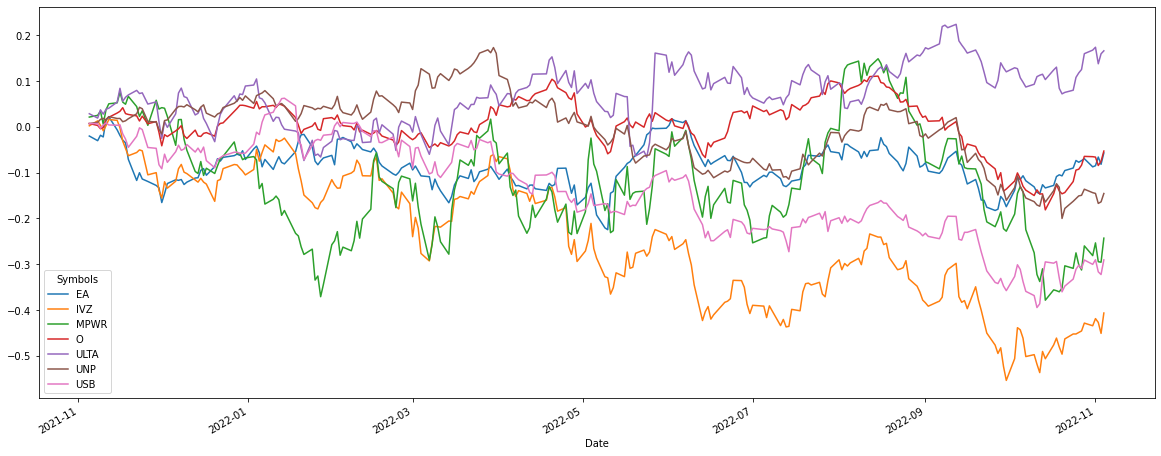

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-06 14:33:05,179|IRAHoldingsAdjustement|INFO|STOCK|EA                  |HOLDING|0.100000
2022-11-06 14:33:05,181|IRAHoldingsAdjustement|INFO|STOCK|IVZ                 |HOLDING|0.150000
2022-11-06 14:33:05,182|IRAHoldingsAdjustement|INFO|STOCK|MPWR                |HOLDING|0.150000
2022-11-06 14:33:05,183|IRAHoldingsAdjustement|INFO|STOCK|O                   |HOLDING|0.150000
2022-11-06 14:33:05,184|IRAHoldingsAdjustement|INFO|STOCK|ULTA                |HOLDING|0.150000
2022-11-06 14:33:05,185|IRAHoldingsAdjustement|INFO|STOCK|UNP                 |HOLDING|0.150000
2022-11-06 14:33:05,185|IRAHoldingsAdjustement|INFO|STOCK|USB                 |HOLDING|0.150000


In [9]:
import ameritrade_functions as amc
import utils

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

2022-11-06 14:33:05,292|WDM|INFO|



====== WebDriver manager ======


2022-11-06 14:33:05,294|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-06 14:33:05,318|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-06 14:33:05,320|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Trying to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_win32.zip


2022-11-06 14:33:05,413|WDM|INFO|Trying to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_win32.zip


Driver has been saved in cache [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62]


2022-11-06 14:33:06,224|WDM|INFO|Driver has been saved in cache [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62]


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,90384S303,ULTA,"Ulta Beauty, Inc. - Common Stock",NASDAQ,EQUITY,451.300,330.7991,0.000,0.00,,...,3.30099,0.0,0.0,0.0,0.0000,,1.31122,751350.0,751347.0,18148250.0
1,902973304,USB,U.S. Bancorp Common Stock,NYSE,EQUITY,63.570,38.3900,1.920,4.48,2022-09-29 00:00:00.000,...,5.83971,0.0,0.0,0.0,0.4800,2022-10-17 00:00:00.000,0.97186,10405700.0,10405695.0,188970940.0
2,907818108,UNP,Union Pacific Corporation Common Stock,NYSE,EQUITY,278.940,183.7000,5.200,2.64,2022-08-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,1.3000,2022-09-30 00:00:00.000,1.10589,3253740.0,3253737.0,62126430.0
3,609839105,MPWR,"Monolithic Power Systems, Inc. - Common Stock",NASDAQ,EQUITY,580.000,301.6900,3.000,0.85,2022-09-29 00:00:00.000,...,20.53904,0.0,0.0,0.0,0.7500,2022-10-14 00:00:00.000,1.09091,1050250.0,1050254.0,15710340.0
4,285512109,EA,Electronic Arts Inc. - Common Stock,NASDAQ,EQUITY,146.720,109.2400,0.760,0.59,2022-11-29 00:00:00.000,...,15.61689,0.0,0.0,0.0,0.1900,2022-12-21 00:00:00.000,0.86052,2377660.0,2377664.0,42033850.0
5,G491BT108,IVZ,Invesco Ltd Common Stock,NYSE,EQUITY,26.589,13.2000,0.750,4.77,2022-11-09 00:00:00.000,...,12.57709,0.0,0.0,0.0,0.1875,2022-12-02 00:00:00.000,1.29678,6116250.0,6116254.0,106874110.0
6,756109104,O,Realty Income Corporation Common Stock,NYSE,EQUITY,75.400,55.5000,2.976,4.72,2022-10-31 00:00:00.000,...,10.25254,0.0,0.0,0.0,0.2480,2022-11-15 00:00:00.000,0.78089,4191030.0,4191029.0,90296080.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

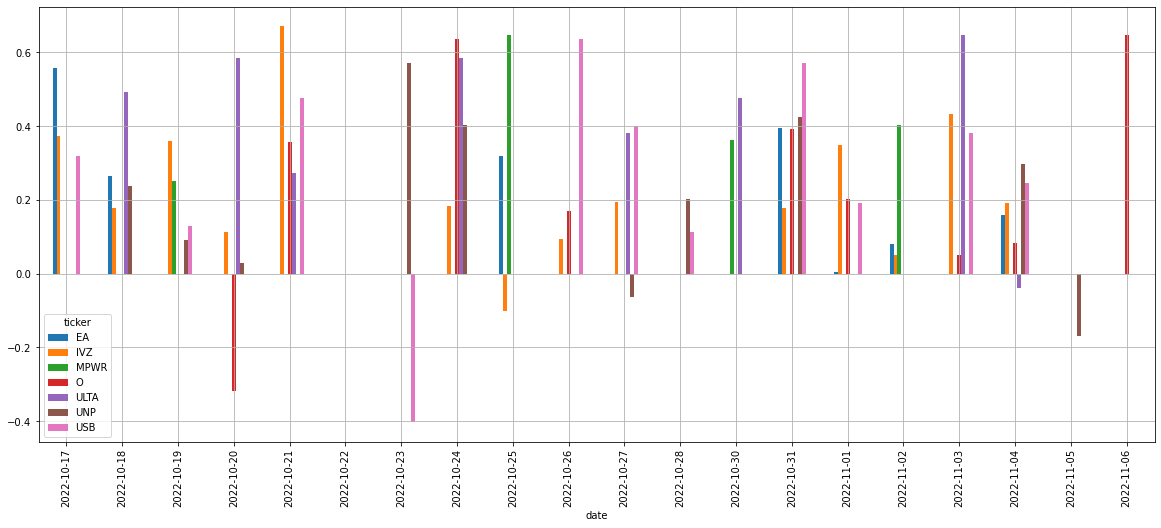

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error('Error: No authorization data: {}'.format(td_ameritrade.authorization))
    raise SystemExit
else:
    logger.info('You have authorization')

logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-06 14:33:51,100|WDM|INFO|



====== WebDriver manager ======


2022-11-06 14:33:51,102|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-06 14:33:51,127|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-06 14:33:51,128|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-06 14:33:51,184|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-06 14:34:30,528|IRAHoldingsAdjustement|INFO|You have authorization
2022-11-06 14:34:30,528|IRAHoldingsAdjustement|INFO|TRADE_DATE|2022-11-06 14:34:30.528632
2022-11-06 14:34:32,869|IRAHoldingsAdjustement|INFO|Full Equity Portfolio:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
15,#---5311,0.0,35.56279,0.0,0.00000,0.0,60.707,60.707,0.0,1851.56,1851.56,60.707,EQUITY,808524805,SCHF,0,0
16,#---5311,0.0,52.14316,0.0,0.00000,0.0,71.973,71.973,0.0,3422.32,3422.32,71.973,EQUITY,922020805,VTIP,0,0
17,#---5311,0.0,59.10313,0.0,0.00000,0.0,35.925,35.925,0.0,1840.80,1840.80,35.925,EQUITY,922042874,VGK,0,0
18,#---5311,0.0,40.44691,0.0,0.00000,0.0,13.224,13.224,0.0,638.59,638.59,13.224,EQUITY,316092501,FNCL,0,0
19,#---5311,0.0,62.05673,0.0,0.00000,0.0,49.000,49.000,0.0,2578.87,2578.87,49.000,EQUITY,192446102,CTSH,0,0
20,#---5311,0.0,30.81202,0.0,0.00000,0.0,34.137,34.137,0.0,783.10,783.10,34.137,EQUITY,808524706,SCHE,0,0
21,#---5311,0.0,48.49797,0.0,0.00000,0.0,64.000,64.000,0.0,3167.36,3167.36,64.000,EQUITY,311900104,FAST,0,0
22,#---5311,0.0,42.61006,0.0,0.00000,0.0,5.088,5.088,0.0,221.18,221.18,5.088,EQUITY,316092303,FSTA,0,0
23,#---5311,0.0,71.79302,0.0,0.00000,0.0,43.000,43.000,0.0,3150.61,3150.61,43.000,EQUITY,674599105,OXY,0,0
24,#---5311,0.0,127.35125,0.0,-0.00016,0.0,16.000,16.000,0.0,2076.16,2076.16,16.000,EQUITY,285512109,EA,0,0


In [12]:
long_term_stocks = default_config['long_term_stocks'].split()

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(
    utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell['symbol'].isin(long_term_stocks)]
logger.info('Stocks to sell:')
display(stocks_to_sell)

2022-11-06 14:34:33,176|IRAHoldingsAdjustement|INFO|Stocks to sell:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
19,#---5311,0.0,62.05673,0.0,0.00000,0.0,49.0,49.0,0.0,2578.87,2578.87,49.0,EQUITY,192446102,CTSH,0,0
21,#---5311,0.0,48.49797,0.0,0.00000,0.0,64.0,64.0,0.0,3167.36,3167.36,64.0,EQUITY,311900104,FAST,0,0
23,#---5311,0.0,71.79302,0.0,0.00000,0.0,43.0,43.0,0.0,3150.61,3150.61,43.0,EQUITY,674599105,OXY,0,0
24,#---5311,0.0,127.35125,0.0,-0.00016,0.0,16.0,16.0,0.0,2076.16,2076.16,16.0,EQUITY,285512109,EA,0,0
27,#---5311,0.0,76.49000,0.0,0.00000,0.0,41.0,41.0,0.0,3164.38,3164.38,41.0,EQUITY,30040W108,ES,0,0
31,#---5311,0.0,45.10101,0.0,0.00000,0.0,69.0,69.0,0.0,3380.31,3380.31,69.0,EQUITY,03743Q108,APA,0,0
32,#---5311,0.0,47.37985,0.0,0.00000,0.0,66.0,66.0,0.0,3116.52,3116.52,66.0,EQUITY,717081103,PFE,0,0


### Submit and montior sell orders

In [13]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

2022-11-06 14:34:33,217|WDM|INFO|



====== WebDriver manager ======


2022-11-06 14:34:33,221|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-06 14:34:33,258|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-06 14:34:33,259|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-06 14:34:33,319|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing SELL order on #---5311 for 49.0 shares of CTSH...
Placed SELL order on #---5311 for 49.0 shares of CTSH
Placing SELL order on #---5311 for 64.0 shares of FAST...
Placed SELL order on #---5311 for 64.0 shares of FAST
Placing SELL order on #---5311 for 43.0 shares of OXY...
Placed SELL order on #---5311 for 43.0 shares of OXY
Placing SELL order on #---5311 for 16.0 shares of EA...
Placed SELL order on #---5311 for 16.0 shares of EA
Placing SELL order on #---5311 for 41.0 shares of ES...
Placed SELL order on #---5311 for 41.0 shares of ES
Placing SELL order on #---5311 for 69.0 shares of APA...
Placed SELL order on #---5311 for 69.0 shares of APA
Placing SELL order on #---5311 for 66.0 shares of PFE...
Placed SELL order on #---5311 for 66.0 shares of PFE


In [15]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


2022-11-07 10:18:45,724|WDM|INFO|



====== WebDriver manager ======


2022-11-07 10:18:45,726|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-07 10:18:45,776|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-07 10:18:45,778|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-07 10:18:45,867|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
All stocks sold|['CTSH' 'FAST' 'OXY' 'EA' 'ES' 'APA' 'PFE']


In [16]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance            0.00000
initialBalances_totalCash              0.00000
initialBalances_equity             87417.24000
initialBalances_moneyMarketFund      430.69000
currentBalances_cashBalance        22559.11000
currentBalances_equity             87570.37000
currentBalances_moneyMarketFund      430.69000
current_return                         0.00175
Name: #---5311, dtype: float64

22559.11
430.69
2022-11-07 10:20:40,122|IRAHoldingsAdjustement|INFO|INVESTMENT_AMT|22989.8


In [17]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 22989.8
Amount to invest: 22000


In [18]:
long_weights

,optimalWeights
EA,0.10
IVZ,0.15
MPWR,0.15
O,0.15
ULTA,0.15
UNP,0.15
USB,0.15


In [19]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-07 10:20:56.740035
Initial investment amount: 22000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
EA,130.720,0.10,2200.0,16
IVZ,15.655,0.15,3300.0,210
MPWR,346.640,0.15,3300.0,9
O,62.920,0.15,3300.0,52
ULTA,413.950,0.15,3300.0,7
UNP,196.130,0.15,3300.0,16
USB,43.050,0.15,3300.0,76


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
EA,130.720,0.10,2200.0,16,2091.52
IVZ,15.655,0.15,3300.0,210,3287.55
MPWR,346.640,0.15,3300.0,9,3119.76
O,62.920,0.15,3300.0,52,3271.84
ULTA,413.950,0.15,3300.0,7,2897.65
UNP,196.130,0.15,3300.0,16,3138.08
USB,43.050,0.15,3300.0,76,3271.80


Total cost: 21078.2


### Place buy orders

In [20]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,90384S303,ULTA,"Ulta Beauty, Inc. - Common Stock",NASDAQ,EQUITY,451.300,330.7991,0.000,0.00,,...,3.30099,0.0,0.0,0.0,0.0000,,1.31122,751350.0,751347.0,18148250.0
1,902973304,USB,U.S. Bancorp Common Stock,NYSE,EQUITY,63.570,38.3900,1.920,4.48,2022-09-29 00:00:00.000,...,5.83971,0.0,0.0,0.0,0.4800,2022-10-17 00:00:00.000,0.97186,10405700.0,10405695.0,188970940.0
2,907818108,UNP,Union Pacific Corporation Common Stock,NYSE,EQUITY,278.940,183.7000,5.200,2.64,2022-08-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,1.3000,2022-09-30 00:00:00.000,1.10589,3253740.0,3253737.0,62126430.0
3,609839105,MPWR,"Monolithic Power Systems, Inc. - Common Stock",NASDAQ,EQUITY,580.000,301.6900,3.000,0.85,2022-09-29 00:00:00.000,...,20.53904,0.0,0.0,0.0,0.7500,2022-10-14 00:00:00.000,1.09091,1050250.0,1050254.0,15710340.0
4,285512109,EA,Electronic Arts Inc. - Common Stock,NASDAQ,EQUITY,146.720,109.2400,0.760,0.59,2022-11-29 00:00:00.000,...,15.61689,0.0,0.0,0.0,0.1900,2022-12-21 00:00:00.000,0.86052,2377660.0,2377664.0,42033850.0
5,G491BT108,IVZ,Invesco Ltd Common Stock,NYSE,EQUITY,26.589,13.2000,0.750,4.77,2022-11-09 00:00:00.000,...,12.57709,0.0,0.0,0.0,0.1875,2022-12-02 00:00:00.000,1.29678,6116250.0,6116254.0,106874110.0
6,756109104,O,Realty Income Corporation Common Stock,NYSE,EQUITY,75.400,55.5000,2.976,4.72,2022-10-31 00:00:00.000,...,10.25254,0.0,0.0,0.0,0.2480,2022-11-15 00:00:00.000,0.78089,4191030.0,4191029.0,90296080.0


In [21]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-07 10:21:12.165519
2022-11-07 10:21:12,165|WDM|INFO|



====== WebDriver manager ======


2022-11-07 10:21:12,167|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-07 10:21:12,226|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-07 10:21:12,227|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-07 10:21:12,293|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing BUY order on 495855311 for 16.0 shares of EA:EQUITY...
Placed BUY order on #---5311 for 16.0 shares of EA
Placing BUY order on 495855311 for 210.0 shares of IVZ:EQUITY...
Placed BUY order on #---5311 for 210.0 shares of IVZ
Placing BUY order on 495855311 for 9.0 shares of MPWR:EQUITY...
Placed BUY order on #---5311 for 9.0 shares of MPWR
Placing BUY order on 495855311 for 52.0 shares of O:EQUITY...
Placed BUY order on #---5311 for 52.0 shares of O
Placing BUY order on 495855311 for 7.0 shares of ULTA:EQUITY...
Placed BUY order on #---5311 for 7.0 shares of ULTA
Placing BUY order on 495855311 for 16.0 shares of UNP:EQUITY...
Placed BUY order on #---5311 for 16.0 shares of UNP
Placing BUY order on 495855311 for 76.0 shares of USB:EQUITY...
Placed BUY order on #---5311 for 76.0 shares of USB


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]